- Download Model Weights from https://www.kaggle.com/hypocrites/imageaiweighs
- (Kernel Notebook > File > Add or Upload Data > Datasets > Search By URL > {Above URL})

In [1]:
"""
!pip install imageai --quiet
!pip install tensorflow==1.14.0 --quiet
!pip install tensorflow-gpu==1.14.0 --quiet
"""
pass

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from IPython.display import clear_output
from sklearn import preprocessing

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/csgrads/samad028/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/csgrads/samad028

In [3]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

os.listdir(IMAGEAIWEIGHTS)

['resnet50_coco_best_v2.0.1.h5', 'yolo.h5', 'imageaiweighs.zip']

In [4]:
df_train = pd.read_csv(os.path.join(DATASET_DIR, 'train.csv'))

# Append a col specifying # of cars, inspired by seshadrikolluri/vehicle-angle-prediction-understanding-eda
df_train['NumCars'] = [int((x.count(' ')+1)/7) for x in df_train['PredictionString']]

# df_train.head()

In [5]:
# show_image(imageId=df_train["ImageId"][0],width=12,addMask=True,markCars=df_train["PredictionString"][0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2456
TP 1 FP 0 FN 4


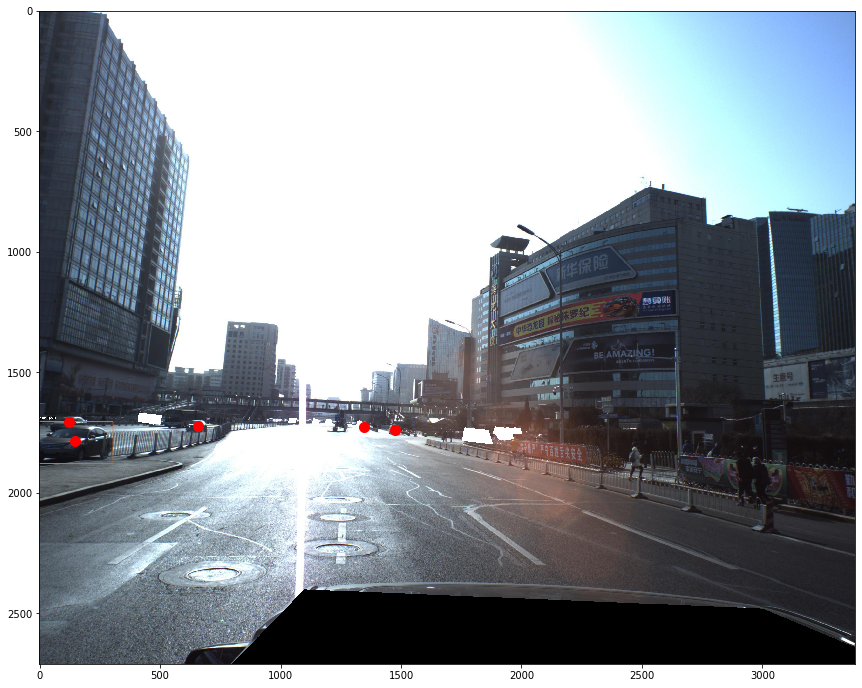

In [6]:
detector = detector_imageai('yolo')

keys = np.array(df_train["ImageId"].keys())
np.random.shuffle(keys)

for key in keys:
    
    #key = 3271 # Just to reproduce the result of a random key taken from print below
    print(key)
    
    image = return_img(imageId=df_train["ImageId"][key])
    
    returned_image, detections = predict_using_detector(detector,image)
    ground_truth = df_train["PredictionString"][key]
                
    TP,FP,FN,TP_points = find_sensitivity(ground_truth,detections)
    print("TP",TP,"FP",FP,"FN",FN)
    
    show_image(img=returned_image,width=15,markCars=ground_truth)
    
    break

In [7]:
def analyse_detector_stage(detectorName,df_data=df_train,detection_probability=50,extract=False):
    
    CSI = 0
    avgCSI = 0
    CSI_temp = 0
    anamoly = ""
    
    df = df_data.copy()
    
    df["DetectedCars"] = ""
    df["TP"] = ""
    df["FP"] = ""
    df["FN"] = ""
    df["CSI"] = ""
    
    if extract:
    
        filename = os.path.join(DATASET_DIR , "detections/"+detectorName+"-"+str(detection_probability)+"-detections.csv")    
        detectionsDict = dict()

        # Open once in w+ mode to clear it
        f = open(filename, "w+")
        f.close()
        newCSV = True
        
    detector = detector_imageai(detectorName)
    totalDetectionsRows = len(df.index)
    countDetectedRows = 0
    countCSIRows = 0

    for instance,row in df.iterrows():
        
        imageId = row["ImageId"]
        
        countDetectedRows += 1
        image = return_img(imageId=imageId)
        ground_truth = df["PredictionString"][instance]
        
        if extract:
            
            # IF extract detections
            
            detections, objects_path = detector.detectCustomObjectsFromImage(
                custom_objects=detector.CustomObjects(car=True),
                display_object_name = False,
                input_image=image, 
                input_type="array",
                output_image_path=os.path.join(DETECTIONS_DIR , detectorName+"-"+str(detection_probability)+"/"+imageId+".jpg"),
                minimum_percentage_probability=detection_probability,
                extract_detected_objects=extract)
                
        else:
            
            returned_image, detections = detector.detectCustomObjectsFromImage(
                custom_objects=detector.CustomObjects(car=True),
                display_object_name = False,
                input_image=image, 
                input_type="array",
                output_type="array",
                minimum_percentage_probability=detection_probability,
                extract_detected_objects=extract)
            
            if totalDetectionsRows == 1:
                print("Showing Image, shortly ...")
                show_image(img=returned_image,width=15,markCars=ground_truth)
        

        TP,FP,FN,TP_points = find_sensitivity(ground_truth,detections)
        
        if extract:
            for eachObject, eachObjectPath in zip(detections, objects_path):
                for TP_point in TP_points:
                    if TP_point["box"] == eachObject["box_points"]:

                        eachObjectPath = imageId+"-"+str(eachObjectPath.split("objects/")[1].split(".")[0].split("-")[1])
                        detectionsDict[eachObjectPath] = dict()
                        detectionsDict[eachObjectPath]["Probability"] = eachObject["percentage_probability"]
                        # Idea: Replace the following x,y,z by the inverse of get_image_coords fn for mean x,y from detected bounding boxes
                        # or Better: Feed bounding box coordinates to future neural network along with image
                        detectionsDict[eachObjectPath]["x1"] = TP_point["x1"]
                        detectionsDict[eachObjectPath]["x2"] = TP_point["x2"]
                        detectionsDict[eachObjectPath]["y1"] = TP_point["y1"]
                        detectionsDict[eachObjectPath]["y2"] = TP_point["y2"]

                        original_string = TP_point["original_string"]

                        for param,value in original_string.items():
                            detectionsDict[eachObjectPath][param] = value
                    

        df.loc[instance,"DetectedCars"] = len(detections)
        df.loc[instance,"TP"] = TP
        df.loc[instance,"FP"] = FP
        df.loc[instance,"FN"] = FN
        
        cars_actual = df["NumCars"][instance]
        cars_predicted = len(detections)       
        
        if (TP+FP+FN) > 0: # Don't Check accuracy when there are no cars
            
            CSI_temp = TP / (TP+FP+FN)
            CSI += CSI_temp
            
            countCSIRows += 1            
            avgCSI = CSI / countCSIRows
            
            """if CSI == -1: # No earlier acc set
                CSI = CSI_temp
            CSI = ( CSI_temp + CSI ) / 2"""
            
            df.loc[instance,"CSI"] = round(CSI_temp,3)
            
        elif cars_actual > 0: # This shouldn't occur when cars in actual are more than 0
            anamoly += f"Anamoly detected for ImageID: {imageId}, (TP+FP+FN)=0 when Actual Cars are {cars_actual}\n"
        
        if totalDetectionsRows > 1:
            clear_output(wait=True)
        
        if(anamoly != ""):
            print(anamoly)
        print(f"{countDetectedRows}/{totalDetectionsRows} Results Predicted. Average CSI so far: {round(avgCSI*100,2)}% (Last {round(CSI_temp*100,2)}%)")
        
        # Generate Detections CSV
        
        if extract:
                
            df_det = pd.DataFrame(detectionsDict)
            df_det = df_det.T
            if(newCSV):
                newCSV = False
                header = True
            else:
                header = False

            # open in append mode
            f = open(filename, 'a')
            df_det.to_csv(f, header=header,index_label='ImageId')
            f.close()
            
            return df, avgCSI, detectionsDict
        
    #df_det = pd.DataFrame(detectionsDict)
    #display(df_det.T)    
    
    return df, avgCSI

In [8]:
df_yolo, CSI = analyse_detector_stage(detectorName='yolo',df_data=df_train.head(10),detection_probability=50,extract=False)
df_yolo

10/10 Results Predicted. Average CSI so far: 48.62% (Last 53.85%)


ImageId                                   PredictionString  NumCars  \
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...        5   
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...        8   
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...       25   
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...        3   
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...       19   
5  ID_679502721  50 0.173958 1.6934 -3.07 17.2953 5.82861 22.82...        3   
6  ID_f681b269f  70 0.201977 -0.0482845 -3.07942 3.94442 5.6771...        9   
7  ID_2803cf7b5  8 0.172028 3.1064 -3.10087 -18.0211 4.98543 27...       10   
8  ID_89449e126  7 0.156087 -0.0318094 -3.06916 2.83965 2.2697 ...        8   
9  ID_2ad1fc1b3  28 0.1514 0.0071941 -3.10048 2.94173 8.31218 4...       12   

   DetectedCars  TP  FP  FN    CSI  
0             4   4   0   1    0.8  
1             4   4   0   4    0.5  
2            12  11   1  14  0.423  
3             1   1   0   2  0.333  
4            13  12   1   7    0.6  
5             3   1   2   2    0.2  
6             6   5   1   4    0.5  
7             3   3   0   7    0.3  
8             7   6   1   2  0.667  
9             8   7   1   5  0.538

In [9]:
"""
Anamoly detected for ImageID: ID_408f58e9f, (TP+FP+FN)=0 when Actual Cars are 7
Anamoly detected for ImageID: ID_c44983aeb, (TP+FP+FN)=0 when Actual Cars are 10
Anamoly detected for ImageID: ID_1a5a10365, (TP+FP+FN)=0 when Actual Cars are 21
Anamoly detected for ImageID: ID_3566f2522, (TP+FP+FN)=0 when Actual Cars are 11
Anamoly detected for ImageID: ID_0e6c355d9, (TP+FP+FN)=0 when Actual Cars are 7
Anamoly detected for ImageID: ID_68fc9ba82, (TP+FP+FN)=0 when Actual Cars are 4
Anamoly detected for ImageID: ID_234456b14, (TP+FP+FN)=0 when Actual Cars are 5
Anamoly detected for ImageID: ID_fd8b62447, (TP+FP+FN)=0 when Actual Cars are 4
Anamoly detected for ImageID: ID_0cf3d5134, (TP+FP+FN)=0 when Actual Cars are 8
Anamoly detected for ImageID: ID_400e4348a, (TP+FP+FN)=0 when Actual Cars are 5
Anamoly detected for ImageID: ID_bb1d991f6, (TP+FP+FN)=0 when Actual Cars are 20
Anamoly detected for ImageID: ID_a792fce8b, (TP+FP+FN)=0 when Actual Cars are 3
Anamoly detected for ImageID: ID_4d238ae90, (TP+FP+FN)=0 when Actual Cars are 19
Anamoly detected for ImageID: ID_fdb989823, (TP+FP+FN)=0 when Actual Cars are 6
Anamoly detected for ImageID: ID_89073c248, (TP+FP+FN)=0 when Actual Cars are 2

"""
pass

Showing Image, shortly ...


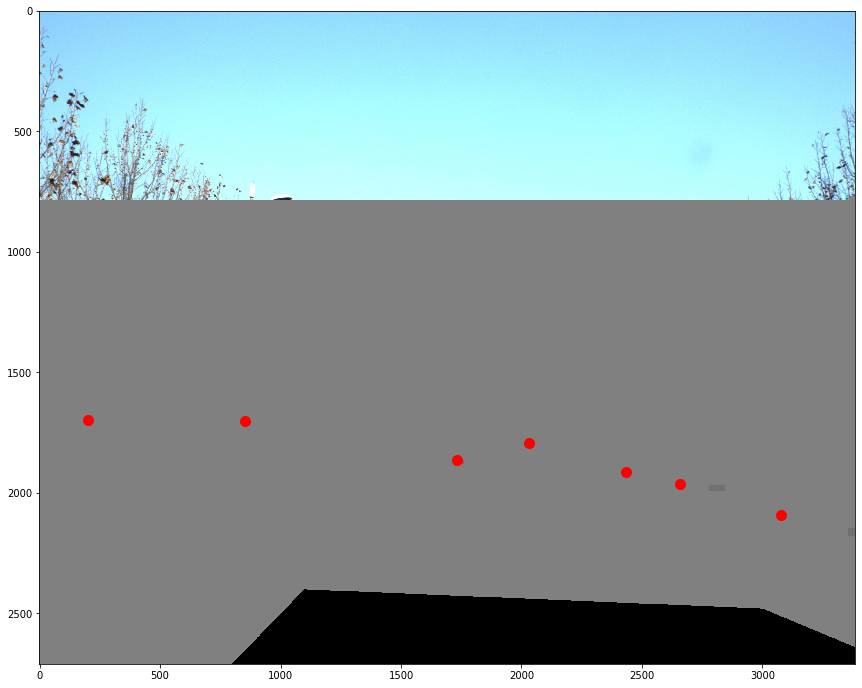

Anamoly detected for ImageID: ID_408f58e9f, (TP+FP+FN)=0 when Actual Cars are 7

1/1 Results Predicted. Average CSI so far: 0% (Last 0%)


ImageId                                   PredictionString  NumCars  \
167  ID_408f58e9f  37 0.130019 0.0131546 -3.02791 7.97754 4.2176 ...        7   

     DetectedCars  TP  FP  FN CSI  
167             0   0   0   0

In [10]:
df_anamoly, CSI = analyse_detector_stage(detectorName='yolo',
                                      df_data=df_train.loc[df_train['ImageId'] == "ID_408f58e9f"],
                                      detection_probability=50,extract=False)
display(df_anamoly)

In [ ]:
#probabs = [5,20,30,50,70,100]
probabs = [5,10,15,20,25,30,35,40,50,60,70,80,90,100]
detectors = ['yolo','resnet']
#df_data = df_train.sample(100)
df_data = df_train.copy()

noFalses = {}
CSIs = {}
FNs = {}
FPs = {}

for detectorName in detectors:
    
    noFalses[detectorName] = []
    CSIs[detectorName] = []
    FNs[detectorName] = []
    FPs[detectorName] = []
    
    for probability in probabs:

        clear_output(wait=True)
        print(f"Checking Detection Probability {probability}% For {detectorName}")

        filename = os.path.join(ANALYSIS_DIR , detectorName+"-"+str(probability)+"-analysis.csv")    
        
        df_prob, CSI = analyse_detector_stage(detectorName=detectorName,df_data=df_data,detection_probability=probability,extract=False)
        CSIs[detectorName].append(CSI*100)

        noFalse = len(df_prob.loc[(df_prob["FP"]==0) & (df_prob["FN"]==0)])
        noFalses[detectorName].append(noFalse)
        
        FP = df_prob["FP"].sum() / (df_prob["FP"].sum()+df_prob["FN"].sum().sum()+df_prob["TP"].sum())
        FN = df_prob["FN"].sum() / (df_prob["FP"].sum()+df_prob["FN"].sum().sum()+df_prob["TP"].sum())
        FPs[detectorName].append(FP)
        FNs[detectorName].append(FN)
        
        df_prob.to_csv(filename)       

Anamoly detected for ImageID: ID_408f58e9f, (TP+FP+FN)=0 when Actual Cars are 7
Anamoly detected for ImageID: ID_c44983aeb, (TP+FP+FN)=0 when Actual Cars are 10
Anamoly detected for ImageID: ID_1a5a10365, (TP+FP+FN)=0 when Actual Cars are 21

902/4262 Results Predicted. Average CSI so far: 49.19% (Last 57.14%)


In [ ]:
# Generate Detection Analysis Plots

"""
   -                solid line style
   --               dashed line style
   -.               dash-dot line style
   :                dotted line style
   .                point marker
   ,                pixel marker
   o                circle marker
   v                triangle_down marker
   ^                triangle_up marker
   <                triangle_left marker
   >                triangle_right marker
   s                square marker
   p                pentagon marker
   *                star marker
"""

linestyles = ['-','--','-.',':']
markerstyles = ['*','s','v','o','<','p','^','.','>']

# CSI

fig, ax = plt.subplots()

for count,detectorName in enumerate(detectors):
    ax.plot(probabs, CSIs[detectorName], label=detectorName, 
            linestyle=linestyles[count%len(linestyles)], marker=markerstyles[count%len(markerstyles)])
ax.set(xlabel='Detection Probability (%)', ylabel='Critical Success Index (%)',
       title=f"Detection analysis on dataset of {len(df_data)} rows out of {len(df_train)}")
ax.grid()
plt.legend(loc='lower left')
filename = os.path.join(ANALYSIS_DIR, f"detector_{len(df_data)}-rows_CSI-analysis.png")   
fig.savefig(filename)
plt.show()


# noFalse

fig, ax = plt.subplots()

for count,detectorName in enumerate(detectors):
    ax.plot(probabs, noFalses[detectorName], label=detectorName, 
            linestyle=linestyles[count%len(linestyles)], marker=markerstyles[count%len(markerstyles)])
ax.set(xlabel='Detection Probability (%)', ylabel='No False Count (#)',
       title=f"Detection analysis on dataset of {len(df_data)} rows out of {len(df_train)}")
ax.grid()
plt.legend(loc='lower right')
filename = os.path.join(ANALYSIS_DIR, f"detector_{len(df_data)}-rows_noFalse-analysis.png")   
fig.savefig(filename)
plt.show()


# FP and FN

fig, ax = plt.subplots()

count = 0
for detectorName in detectors:
    ax.plot(probabs, FNs[detectorName], label=detectorName+" FN", 
            linestyle=linestyles[count%len(linestyles)], marker=markerstyles[count%len(markerstyles)])
    count+=1
    ax.plot(probabs, FPs[detectorName], label=detectorName+" FP", 
            linestyle=linestyles[(count)%len(linestyles)], marker=markerstyles[(count)%len(markerstyles)])
    count+=1
    
ax.set(xlabel='Detection Probability (%)', ylabel='False Counts out of Total (%)',
       title=f"Detection analysis on dataset of {len(df_data)} rows out of {len(df_train)}")
ax.grid()
plt.legend(loc='upper right')
plt.yscale('lineR')
filename = os.path.join(ANALYSIS_DIR, f"detector_{len(df_data)}-rows_FP-FN-analysis.png")   
fig.savefig(filename)
plt.show()